In [1]:
import logging
logging.getLogger().setLevel(logging.INFO)

import mxnet as mx
import numpy as np

/home/poodar/Library/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
fname = mx.test_utils.download('http://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data')
data = np.genfromtxt(fname, delimiter=',')[:, 1:]
label = np.array([ord(l.split(',')[0])-ord('A') for l in open(fname, 'r')])

INFO:root:downloaded http://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data into letter-recognition.data successfully


In [3]:
batch_size = 32
ntrain = int(data.shape[0]*0.8)
train_iter = mx.io.NDArrayIter(data[:ntrain, :], label[:ntrain], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(data[ntrain:, :], label[ntrain:], batch_size)

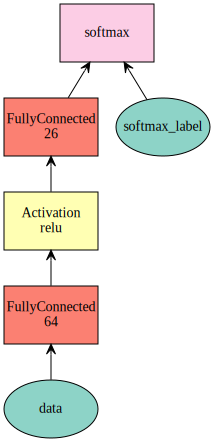

In [21]:
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(net, name='fc1', num_hidden=64)
net = mx.sym.Activation(net, name='relu01', act_type='relu')
net = mx.sym.FullyConnected(net, name='fc2', num_hidden=26)
net = mx.sym.SoftmaxOutput(net, name='softmax')
mx.viz.plot_network(symbol=net) #, shape={'data':(1000, 3, 300, 300)})

# Introduce Module
we can construct a module by specifying the following parameters:
* symbol: the network definition
* context
* data_names: the list of input data variable names
* label_names: the list of input label variable names

In [22]:
mod = mx.mod.Module(symbol=net,
                   context=mx.cpu(),
                   data_names=['data'],
                   label_names=['softmax_label'])

## Internediate-level Interface
let's see how to run training and inference using modules's intermediate level APIs.
to train a module, we need to perform the following steps:
* bind: prepares environment for the computation by allocating memory
* init_params
* init_initializer
* metric.create
* forward
* update_metric
* backward
* update: updates parameters according to the installed optimizer and the gradients computed in the previous forward-backworad batch.

In [28]:
# allocate memory given the input data and label shapes
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
# initialize parameters by uniform random numbers
mod.init_params(initializer=mx.init.Uniform(scale=.1))
# use SGD with learning rate 0.1 to train
mod.init_optimizer(optimizer='adam', optimizer_params=(('learning_rate', 0.1), ))
# use accuracy as the metric
metric = mx.metric.create('acc')
# train 5 epochs, i.e. going over the data iter one pass
for epoch in range(10):
    train_iter.reset()
    metric.reset()
    for batch in train_iter:
        mod.forward(batch, is_train=True)       # compute predictions
        mod.update_metric(metric, batch.label)  # accumulate prediction accuracy
        mod.backward()                          # compute gradients
        mod.update()                            # update parameters
    print('Epoch %d, Training %s' % (epoch, metric.get()))   

/home/poodar/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  after removing the cwd from sys.path.


Epoch 0, Training ('accuracy', 0.8899375)
Epoch 1, Training ('accuracy', 0.8935625)
Epoch 2, Training ('accuracy', 0.889125)
Epoch 3, Training ('accuracy', 0.8923125)
Epoch 4, Training ('accuracy', 0.891875)
Epoch 5, Training ('accuracy', 0.8925)
Epoch 6, Training ('accuracy', 0.8919375)
Epoch 7, Training ('accuracy', 0.8909375)
Epoch 8, Training ('accuracy', 0.893)
Epoch 9, Training ('accuracy', 0.891125)


## High-level Interface

In [30]:
train_iter.reset()

mod = mx.mod.Module(
    symbol=net, 
    context=mx.cpu(),
    data_names=['data'],
    label_names=['softmax_label']
)

mod.fit(
    train_iter,
    eval_data=val_iter,
    optimizer='sgd',
    optimizer_params={'learning_rate':0.1},
    eval_metric='acc',
    num_epoch=80
)

INFO:root:Epoch[0] Train-accuracy=0.370625
INFO:root:Epoch[0] Time cost=0.143
INFO:root:Epoch[0] Validation-accuracy=0.617000
INFO:root:Epoch[1] Train-accuracy=0.631687
INFO:root:Epoch[1] Time cost=0.145
INFO:root:Epoch[1] Validation-accuracy=0.663000
INFO:root:Epoch[2] Train-accuracy=0.697500
INFO:root:Epoch[2] Time cost=0.153
INFO:root:Epoch[2] Validation-accuracy=0.670500
INFO:root:Epoch[3] Train-accuracy=0.734938
INFO:root:Epoch[3] Time cost=0.142
INFO:root:Epoch[3] Validation-accuracy=0.720250
INFO:root:Epoch[4] Train-accuracy=0.761813
INFO:root:Epoch[4] Time cost=0.141
INFO:root:Epoch[4] Validation-accuracy=0.756000
INFO:root:Epoch[5] Train-accuracy=0.778625
INFO:root:Epoch[5] Time cost=0.142
INFO:root:Epoch[5] Validation-accuracy=0.775500
INFO:root:Epoch[6] Train-accuracy=0.794562
INFO:root:Epoch[6] Time cost=0.143
INFO:root:Epoch[6] Validation-accuracy=0.793750
INFO:root:Epoch[7] Train-accuracy=0.801875
INFO:root:Epoch[7] Time cost=0.142
INFO:root:Epoch[7] Validation-accuracy=0

INFO:root:Epoch[64] Train-accuracy=0.898500
INFO:root:Epoch[64] Time cost=0.157
INFO:root:Epoch[64] Validation-accuracy=0.882500
INFO:root:Epoch[65] Train-accuracy=0.901375
INFO:root:Epoch[65] Time cost=0.158
INFO:root:Epoch[65] Validation-accuracy=0.883500
INFO:root:Epoch[66] Train-accuracy=0.900125
INFO:root:Epoch[66] Time cost=0.146
INFO:root:Epoch[66] Validation-accuracy=0.884000
INFO:root:Epoch[67] Train-accuracy=0.899312
INFO:root:Epoch[67] Time cost=0.143
INFO:root:Epoch[67] Validation-accuracy=0.877750
INFO:root:Epoch[68] Train-accuracy=0.897813
INFO:root:Epoch[68] Time cost=0.147
INFO:root:Epoch[68] Validation-accuracy=0.881750
INFO:root:Epoch[69] Train-accuracy=0.898687
INFO:root:Epoch[69] Time cost=0.140
INFO:root:Epoch[69] Validation-accuracy=0.875250
INFO:root:Epoch[70] Train-accuracy=0.901875
INFO:root:Epoch[70] Time cost=0.146
INFO:root:Epoch[70] Validation-accuracy=0.885500
INFO:root:Epoch[71] Train-accuracy=0.899625
INFO:root:Epoch[71] Time cost=0.142
INFO:root:Epoch[7

In [31]:
# Predict and Evaluate
y = mod.predict(val_iter)
assert y.shape == (4000, 26)

In [32]:
# If we need to evaluate on a test set, call score().
score = mod.score(val_iter, ['acc'])
print(score[0][1])
print(score)

0.88225
[('accuracy', 0.88225)]


In [33]:
print(type(score))

<class 'list'>


In [35]:
# save and load
model_prefix = 'mx_mlp'
ckpt = mx.callback.do_checkpoint(model_prefix)

mod = mx.mod.Module(symbol=net)
mod.fit(train_iter, num_epoch=50, epoch_end_callback=ckpt)

INFO:root:Epoch[0] Train-accuracy=0.084562
INFO:root:Epoch[0] Time cost=0.143
INFO:root:Saved checkpoint to "mx_mlp-0001.params"
INFO:root:Epoch[1] Train-accuracy=0.270062
INFO:root:Epoch[1] Time cost=0.141
INFO:root:Saved checkpoint to "mx_mlp-0002.params"
INFO:root:Epoch[2] Train-accuracy=0.454313
INFO:root:Epoch[2] Time cost=0.142
INFO:root:Saved checkpoint to "mx_mlp-0003.params"
INFO:root:Epoch[3] Train-accuracy=0.553562
INFO:root:Epoch[3] Time cost=0.146
INFO:root:Saved checkpoint to "mx_mlp-0004.params"
INFO:root:Epoch[4] Train-accuracy=0.613750
INFO:root:Epoch[4] Time cost=0.148
INFO:root:Saved checkpoint to "mx_mlp-0005.params"
INFO:root:Epoch[5] Train-accuracy=0.650375
INFO:root:Epoch[5] Time cost=0.143
INFO:root:Saved checkpoint to "mx_mlp-0006.params"
INFO:root:Epoch[6] Train-accuracy=0.676937
INFO:root:Epoch[6] Time cost=0.151
INFO:root:Saved checkpoint to "mx_mlp-0007.params"
INFO:root:Epoch[7] Train-accuracy=0.699438
INFO:root:Epoch[7] Time cost=0.145
INFO:root:Saved che

In [36]:
sym, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, 3)
assert sym.tojson() == net.tojson()

mod.set_params(arg_params, aux_params)

In [38]:
# if we just want to resume training from a saved ckpt, instead of calling set_params, we can directly fall fit()
# passing the loaded parameters, so that fit() knows to start from  those parameters instead of initializing randomly
# we also set the begin_epoch parameters so that fit() knows we are resuming from a previously saved epoch
mod = mx.mod.Module(symbol=sym)
mod.fit(
    train_iter,
    num_epoch=21,
    arg_params=arg_params,
    aux_params=aux_params,
    begin_epoch=40
)
# assert score[0][1] > 0.77